In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima  # For automatic ARIMA parameter selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#  Load Preprocessed Data
tsla = pd.read_csv('../data/TSLA_cleaned.csv', index_col='Date', parse_dates=True)
tsla = tsla[['Close', 'Return']]  # We only need these columns

In [ ]:
# Train-Test Split (80-20 chronological)
split_date = '2023-12-31'
train = tsla.loc[:split_date]
test = tsla.loc[split_date:]
print(f"Train size: {len(train)}, Test size: {len(test)}")
print(f"Test period: {test.index[0].date()} to {test.index[-1].date()}")

Train size: 2136, Test size: 395
Test period: 2024-01-02 to 2025-07-30


In [ ]:
#  ARIMA Modeling
# Auto-select best ARIMA parameters
auto_model = auto_arima(train['Close'], seasonal=False, trace=True)
p, d, q = auto_model.order

# Fit ARIMA
arima_model = ARIMA(train['Close'], order=(p,d,q))
arima_results = arima_model.fit()

# Forecast
arima_forecast = arima_results.forecast(steps=len(test))



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12643.984, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12648.499, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12648.476, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12648.421, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12649.783, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12647.933, Time=2.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.662 seconds


In [ ]:
# LSTM Preparation
# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Close']])
test_scaled = scaler.transform(test[['Close']])


# Create sequences
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [ ]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, verbose=1)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0349
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.5179e-04
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.5368e-04
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5064e-04
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3015e-04
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8031e-04
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.7046e-04
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7210e-04
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.4862e-04


In [13]:
# Cell 7: Model Evaluation
def evaluate(name, actual, predicted):
    actual = actual[-len(predicted):]  # Align lengths
    return {
        'Model': name,
        'MAE': mean_absolute_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted))
    }

# ARIMA metrics
arima_metrics = evaluate('ARIMA', test['Close'], arima_forecast)

# LSTM metrics
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast).flatten()
lstm_metrics = evaluate('LSTM', test['Close'].iloc[30:], lstm_forecast)

# Compare
pd.DataFrame([arima_metrics, lstm_metrics])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,Model,MAE,RMSE
0,ARIMA,0.133897,0.165779
1,LSTM,0.030355,0.041641


In [15]:
# Export LSTM forecast as returns (for portfolio optimization)
best_forecast = pd.Series(lstm_forecast, index=test.index[30:], name='TSLA_Forecast')

# Convert forecasted prices to daily returns
forecasted_returns = best_forecast.pct_change().dropna()
forecasted_returns.to_csv('../data/TSLA_forecasted_returns.csv')

print("✅ Forecast saved to '../data/TSLA_forecasted_returns.csv'")
print("Sample forecasted returns:", forecasted_returns.head())

✅ Forecast saved to '../data/TSLA_forecasted_returns.csv'
Sample forecasted returns: Date
2024-02-15    0.002875
2024-02-16    0.013774
2024-02-20    0.011683
2024-02-21    0.004938
2024-02-22    0.005719
Name: TSLA_Forecast, dtype: float32


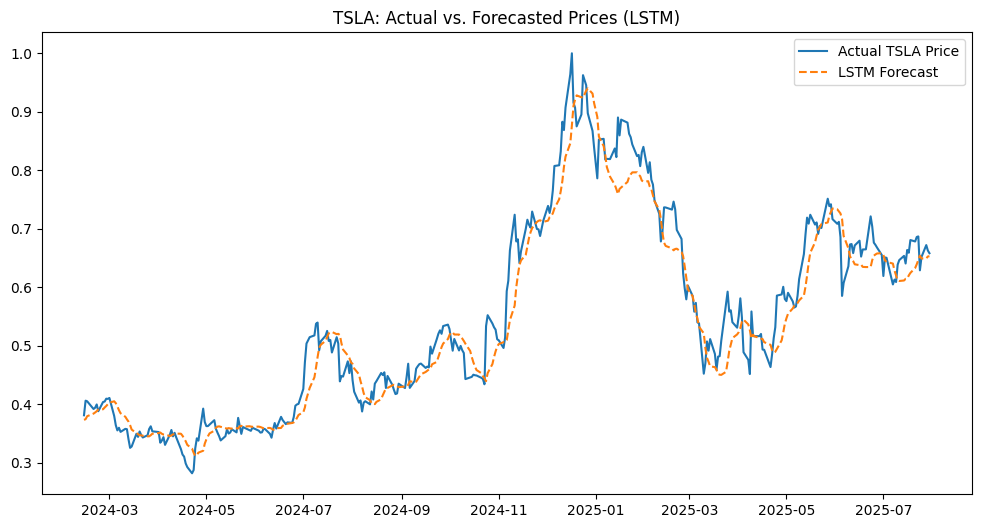

In [16]:
# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(test['Close'][30:], label='Actual TSLA Price')
plt.plot(best_forecast, label='LSTM Forecast', linestyle='--')
plt.title('TSLA: Actual vs. Forecasted Prices (LSTM)')
plt.legend()
plt.show()